# jiles_atherton.ipynb
This notebook demonstrates the creation and use of a Jiles-Atherton magnetic hysteresis model using `rshyst`.

**Documentation**
  * `JilesAtherton` documentation
  * `rshyst` documentation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from rshyst import JilesAtherton, constants

## Constructing a Jiles-Atherton model with `rshyst`
We create a Jiles-Atherton model for grade 20 steel in the cell below by defining a dictionary containing a field step-size (```dH```), physical parameters of the model, and a choice of numerical integrator (see JilesAtherton documentation):

In [2]:
# Set Jiles-Atherton model parameters for low-carbon steel
ja_params = {
    'dH' : 10,
    'sat_tol': 2.5e-4,
    'alpha': 4.93e-4,
    'a': 399,
    'Ms': 1.35e6,
    'k': 300,
    'c': 0.120,
    'wa': 0,
    'Ka': 0,
    'theta': 0,
    'phi': 0,
    'integrator' : 'RK45',
}

# Construct the Jiles-Atherton hysteresis model
ja_model = JilesAtherton(**ja_params)

Once a model has been created, it can be stored using the `save` method and loaded using the `load` class method:

In [3]:
# Saving a constructed model
save_model = False
if save_model:
    ja_model.save("path/to/store/model.pkl")

# Loading a saved model
load_model = False
if load_model:
    ja_model = JilesAtherton.load("path/to/stored/model.pkl")

## Using the Jiles-Atherton model


On initialization, hysteresis models contain definitions for the major hyseresis loop (```H_major``` and ```M_major```), as well as the magnetic `remanence` and `coercivity`.

In the next cell we use the model created above to compute hysteresis quantities for the following use cases:
* Computing a minor hysteresis loop reaching 1/5 of the saturation field
* Computing a portion of the major hysteresis loop, beginning at a turnaround point
* Computing an interpolated magnetic flux density at an arbitrary, prescribed point
* Computing a portion of the major hysteresis loop beginning at a prescribed point

In [4]:
# Extract existing information from Jiles-Atherton model
HMaj = ja_model.H_major
MMaj = ja_model.M_major
Hc = ja_model.coercivity[1]
Mr = ja_model.remanence[0]

# Use Jiles-Atherton model to compute minor loop
minor_path = [
    [0, HMaj.max()/5],
    [HMaj.max()/5, -HMaj.max()/5],
    [-HMaj.max()/5, HMaj.max()/5]
]
HMin, MMin = ja_model.path(minor_path, 0.)

# Use Jiles-Atherton model to compute partial major loop curve
partial_path = [[HMaj.max(), 0]]
HPart, MPart = ja_model.path(partial_path, MMaj.max())

# Use Jiles-Atherton model to compute magnetization for arbitrary applied field
HPoint = -1050.8
MPointU = ja_model.point(HPoint, 'upper')

# Use Jiles-Atherton model to compute partial major loop starting at arbitrary point
point_path = [[.5 * HPoint, 0.]]
MPointL = ja_model.point(.5 * HPoint, 'lower')
HPP, MPP = ja_model.path(point_path, MPointL)

# Convert values to Tesla for plotting
Hc *= constants.MU0
Mr *= constants.MU0
HPoint *= constants.MU0
MPointU *= constants.MU0
for val in [HMaj, HMin, HPart, HPP, MMaj, MMin, MPart, MPP]:
    val *= constants.MU0

With all of these quantities computed, we can get a better idea of each model use-case by plotting:

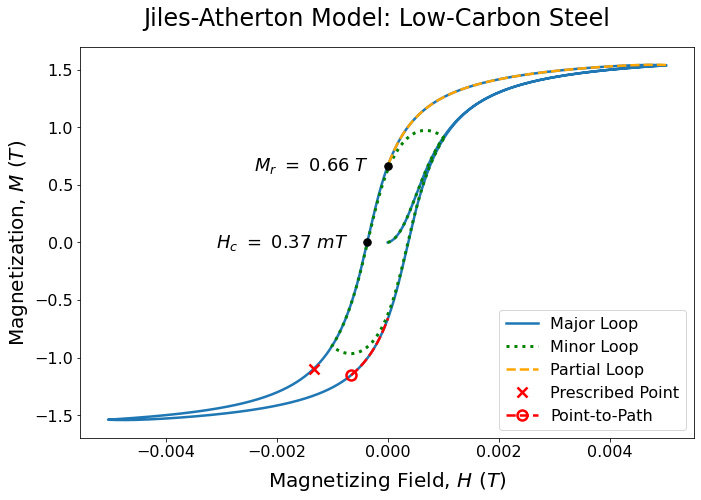

In [6]:
fig, ax = plt.subplots(figsize=(11,7))
fig.suptitle(r"Jiles-Atherton Model: Low-Carbon Steel",fontsize=24,y=.98)
ax.plot(HMaj, MMaj, lw=2.5,label=r"Major Loop")
ax.plot(HMin, MMin, ':', color='g', lw=3, label=r"Minor Loop")
ax.plot(HPart, MPart, '--', color='orange', lw=2.5, label=r"Partial Loop")
ax.plot(HPoint, MPointU, 'x', color='red', ms=10, mew=2.5, label=r"Prescribed Point")
ax.plot(HPP, MPP, 'r--', lw=2.5, marker='o', mfc='none', ms=10, mew=2.5, markevery=[0], label=r"Point-to-Path")
ax.plot(Hc, 0, 'ko', ms=7.5)
ax.text(Hc-HMaj.max()/15, 0, r"$H_c\ =\ {:.2f}\ mT$".format(abs(Hc*1e3)), ha='right', va='center', fontsize=18)
ax.plot(0, Mr, 'ko', ms=7.5)
ax.text(-HMaj.max()/15, Mr, r"$M_r\ =\ {:.2f}\ T$".format(Mr), ha='right', va='center', fontsize=18)
ax.legend(fontsize=16, loc='lower right')
ax.axis(1.1*np.array([HMaj.min(), HMaj.max(), MMaj.min(), MMaj.max()]))
ax.set_xlabel(r"Magnetizing Field, $H\ (T)$", fontsize=20, labelpad=10)
ax.set_ylabel(r"Magnetization, $M\ (T)$",fontsize=20)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)